In [43]:
using Interpolations, Optim, BenchmarkTools, QuantEcon, Distributions
const agrid = exp.(range(log(1), stop = log(200), length = 100 )) .- 1
uc(c) = c > 0 ? c^(-1.5)/-1.5 : -Inf
u(a, ap, x) =  uc(a - ap + x + freemoney)
maxap(a, x) = a + x
const beta = 0.96
using Random
Random.seed!(2)
mc = QuantEcon.tauchen(20, .8, .5)
const ρ = 0.8
const σ_e = 0.5
const P = mc.p
const xgrid = exp.(mc.state_values) .+ 0.1
const tol = 1e-2
const freemoney = 0.01


## Now we want instead VF to be a sparse grid defined on
# [amin, amax] x [xmin, xmax]
# later let's add beta to the space too
using Tasmanian
using Expectations
using LinearAlgebra


# Bellman step given evf and x
# evf is a function which provides E[VF[a', x] | a'], integrating over x
# We will update VF for each value of a
function bellman(evf, a, x)
    obj = ap -> -(u(a, ap, x) + beta * evf(ap))
    upper = min(maxap(a, x), agrid[end])
    sol = optimize(obj, agrid[1], .99*upper)
    vf, pol = -sol.minimum, sol.minimizer
    return vf, pol
end

## Compute the expected value function
## Returns a function of a giving E[VF[a', x] | a']
## Integrates over x
const dist = Normal(0, σ_e)
const E = Expectations.expectation(dist, n = 10)

function vf_expectation(tsg, x)
    function evf(a)
        xmin, xmax = minimum(xgrid), maximum(xgrid)
        # Interpolation not defined outside the grid, so clamp it
        # Shift the nodes by the mean, which is ρx. Variance is constant
        points = [[a for i in 1:10] clamp.(exp.(nodes(E) .+ ρ*x), xmin, xmax)]
        vals = Tasmanian.evaluateBatch(tsg, points)
        val = E*vals
    end
end

function makeInitialGrid()
    iDim = 2
    iOut = 1
    iDepth = 5
    tsg = Tasmanian.TasmanianSG(iDim,iOut,iDepth)
    which_basis = 2 #1= linear basis functions -> Check the manual for other options
    Tasmanian.makeLocalPolynomialGrid!(tsg,iOrder=which_basis,sRule="localp")#, ilevelLimits = [7 for i in 1:iDim])
    #Tasmanian.makeWaveletGrid!(tsg,iOrder=which_basis)#, ilevelLimits = [7 for i in 1:iDim])
    doms = [minimum(agrid) maximum(agrid)
    minimum(xgrid) maximum(xgrid)]
    Tasmanian.setDomainTransform!(tsg, doms)
    tsg
end

function test_serial(J)
    tol = 1e-3
    tsg = makeInitialGrid()
    grid = Tasmanian.getPoints(tsg) # (a, x)
    VF = zeros(size(grid, 1))
    pols = zeros(size(grid, 1))
    Tasmanian.loadNeededPoints!(tsg, VF)
    for i in 1:10
        tsgnew = makeInitialGrid()
        grid = Tasmanian.getPoints(tsgnew) # (a, x)
        vfnew = zeros(size(grid, 1))
        for j = 1:J
            needpoints = Tasmanian.getNeededPoints(tsgnew)
            needvals = zeros(size(needpoints, 1))
            @assert length(size(needpoints)) == 2
            for (p_nx, p) in enumerate(eachrow(needpoints))
                a = p[1]; x = p[2]
                vfe = vf_expectation(tsg, x) # On OLD grid
                vf, pol = bellman(vfe, a, x)
                needvals[p_nx] = vf
            end
            Tasmanian.loadNeededPoints!(tsgnew, needvals)
            Tasmanian.setSurplusRefinement!(tsgnew, tol, sCriteria="classic")
            @show Tasmanian.getNumPoints(tsgnew)
        end
        err = norm(Tasmanian.evaluateBatch(tsg, grid |> collect) .- Tasmanian.evaluateBatch(tsgnew, grid |> collect))
        @show err
        tsg = tsgnew
    end
    grid = Tasmanian.getPoints(tsg) # (a, x)
    return VF, pols, grid, tsg
end

test_serial (generic function with 1 method)

In [44]:
## IMPORTANT
# Tasmanian is 10x faster if I compile it myself, instead of using the one
# packaged with Tasmanian.jl

vfall, polall, g, t = test_serial(8);

Tasmanian.getNumPoints(tsgnew) = 145
Tasmanian.getNumPoints(tsgnew) = 168
Tasmanian.getNumPoints(tsgnew) = 200
Tasmanian.getNumPoints(tsgnew) = 248
Tasmanian.getNumPoints(tsgnew) = 308
Tasmanian.getNumPoints(tsgnew) = 382
Tasmanian.getNumPoints(tsgnew) = 464
Tasmanian.getNumPoints(tsgnew) = 554
err = 7.96149598530352
Tasmanian.getNumPoints(tsgnew) = 145
Tasmanian.getNumPoints(tsgnew) = 165
Tasmanian.getNumPoints(tsgnew) = 199
Tasmanian.getNumPoints(tsgnew) = 249
Tasmanian.getNumPoints(tsgnew) = 317
Tasmanian.getNumPoints(tsgnew) = 413
Tasmanian.getNumPoints(tsgnew) = 533
Tasmanian.getNumPoints(tsgnew) = 695
err = 0.7612279271807467
Tasmanian.getNumPoints(tsgnew) = 145
Tasmanian.getNumPoints(tsgnew) = 165
Tasmanian.getNumPoints(tsgnew) = 199
Tasmanian.getNumPoints(tsgnew) = 249
Tasmanian.getNumPoints(tsgnew) = 325
Tasmanian.getNumPoints(tsgnew) = 446
Tasmanian.getNumPoints(tsgnew) = 636
Tasmanian.getNumPoints(tsgnew) = 955
err = 0.14775444570661692
Tasmanian.getNumPoints(tsgnew) = 145
T

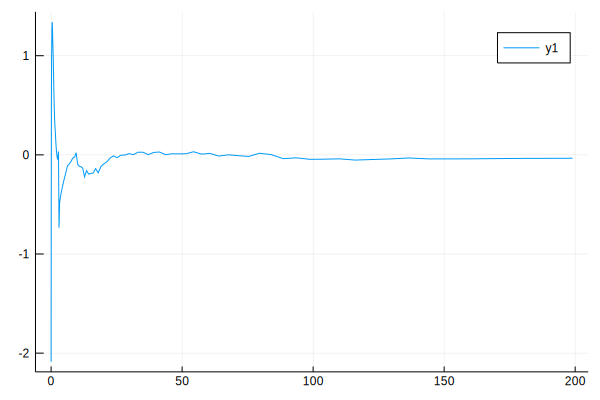

In [45]:
using Plots
denseg = [j == 1 ? agrid[i] : 0.5 for i in eachindex(agrid), j in 1:2]
f = Tasmanian.evaluateBatch(t, denseg)
plot(denseg[:, 1], f)

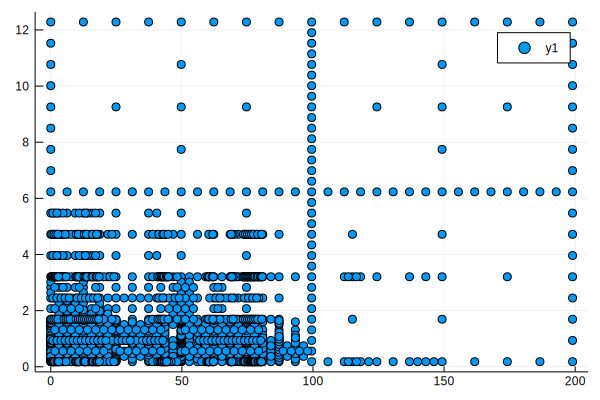

In [46]:
scatter(Tasmanian.getPoints(t)[:, 1], Tasmanian.getPoints(t)[:, 2])

In [47]:
vfall, polall, g, t = test_serial(15);

Tasmanian.getNumPoints(tsgnew) = 145
Tasmanian.getNumPoints(tsgnew) = 168
Tasmanian.getNumPoints(tsgnew) = 200
Tasmanian.getNumPoints(tsgnew) = 248
Tasmanian.getNumPoints(tsgnew) = 308
Tasmanian.getNumPoints(tsgnew) = 382
Tasmanian.getNumPoints(tsgnew) = 464
Tasmanian.getNumPoints(tsgnew) = 554
Tasmanian.getNumPoints(tsgnew) = 646
Tasmanian.getNumPoints(tsgnew) = 740
Tasmanian.getNumPoints(tsgnew) = 830
Tasmanian.getNumPoints(tsgnew) = 916
Tasmanian.getNumPoints(tsgnew) = 988
Tasmanian.getNumPoints(tsgnew) = 1048
Tasmanian.getNumPoints(tsgnew) = 1096
err = 7.96149598530352
Tasmanian.getNumPoints(tsgnew) = 145
Tasmanian.getNumPoints(tsgnew) = 165
Tasmanian.getNumPoints(tsgnew) = 197
Tasmanian.getNumPoints(tsgnew) = 245
Tasmanian.getNumPoints(tsgnew) = 305
Tasmanian.getNumPoints(tsgnew) = 377
Tasmanian.getNumPoints(tsgnew) = 459
Tasmanian.getNumPoints(tsgnew) = 547
Tasmanian.getNumPoints(tsgnew) = 639
Tasmanian.getNumPoints(tsgnew) = 731
Tasmanian.getNumPoints(tsgnew) = 821
Tasmanian.get

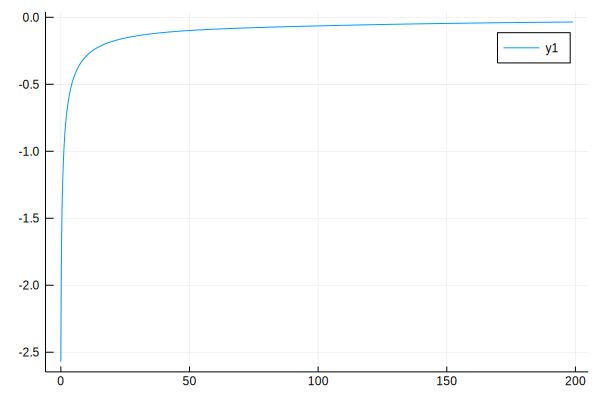

In [48]:
denseg = [j == 1 ? agrid[i] : 0.5 for i in eachindex(agrid), j in 1:2]
f = Tasmanian.evaluateBatch(t, denseg)
plot(denseg[:, 1], f)

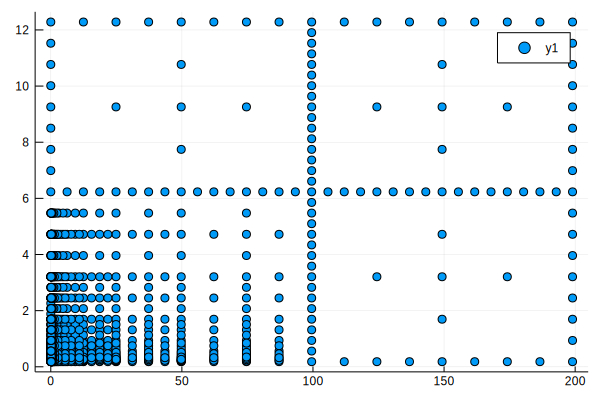

In [49]:
scatter(Tasmanian.getPoints(t)[:, 1], Tasmanian.getPoints(t)[:, 2])